In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [24]:
pce = pd.read_csv("PCE-qtrly.csv")
gdp = pd.read_csv("GDP-qtrly.csv")

pce_growth = pd.read_csv("PCE-growth-qtrly.csv")
gdp_growth = pd.read_csv("GDP-growth-qtrly.csv")

In [25]:
df = pce.merge(gdp, on="DATE", how="right")
df = df.merge(pce_growth, how="right", on="DATE")
df = df.merge(gdp_growth, how="right", on="DATE")

In [26]:
df["DATE"] = pd.to_datetime(df.DATE, format="%Y-%m-%d")
df["PCE_PCH"] = df.PCE_PCH.astype("float64")

In [27]:
df.rename(mapper={
    "GDP_PCH": "GDP_Change",
    "PCE_PCH": "PCE_Change"
}, axis="columns",
inplace=True)

In [28]:
df.to_csv("macro-data.csv", index=False)

In [29]:
df["category"] = df.DATE.map(lambda x: "before 2020" if x.year < 2020
                             else "2020-21" if x.year >= 2020 and x.year <= 2021
                             else "after 2021")

In [30]:
def plot(df, feature, mark_drastic=True):
  cat = df.category.unique()
  fig, ax = plt.subplots()
  colour = ["blue", "red"]
  df_cats = []
  for i, c in enumerate(cat):
    df_cats.append(df.loc[df.category==c].reset_index(drop=True))

  df_cats[1] = pd.DataFrame(df_cats[0].loc[len(df_cats[0])-1]).transpose().append(df_cats[1][:])
  df_cats[1] = df_cats[1].append(pd.DataFrame(df_cats[2].loc[0]).transpose())

  for i, df_cat in enumerate(df_cats):
    df_cat.plot(x="DATE", y=feature, 
                  ax=ax, c=colour[i%2])
  ax.set_title(feature + " through 2002 to 2023")
  ax.set_ylabel(feature)
  ax.legend(cat)
  if mark_drastic == True:
    ax.plot(df.DATE, [2] * 84, color="black")
    ax.plot(df.DATE, [-2] * 84, color="black")
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              df[feature].values[np.newaxis],
              cmap='gist_gray', alpha=0.7)
  plt.grid(ax)
  fig.savefig(feature + "-02-23.jpeg")

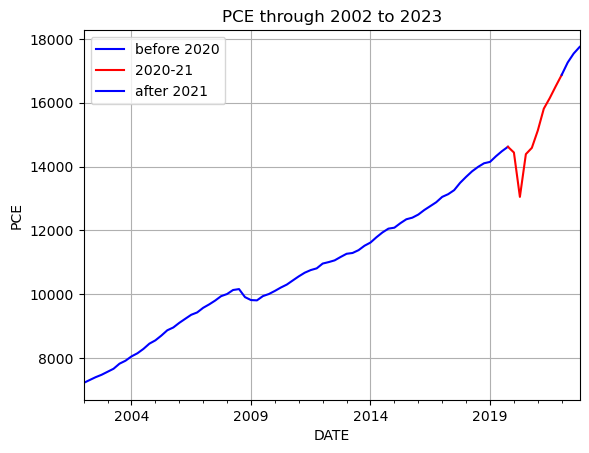

In [31]:
plot(df, "PCE", mark_drastic=False)

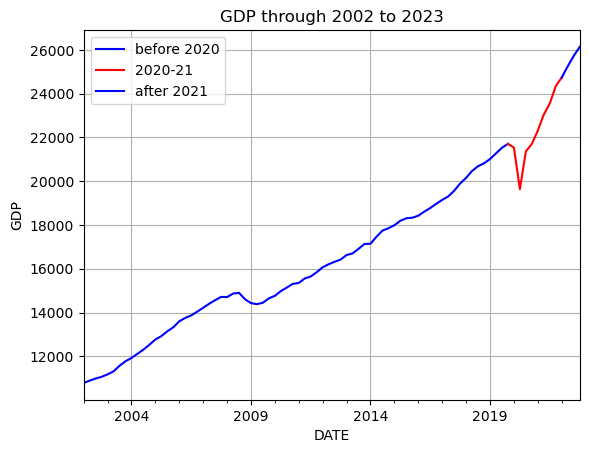

In [32]:
plot(df, "GDP", mark_drastic=False)

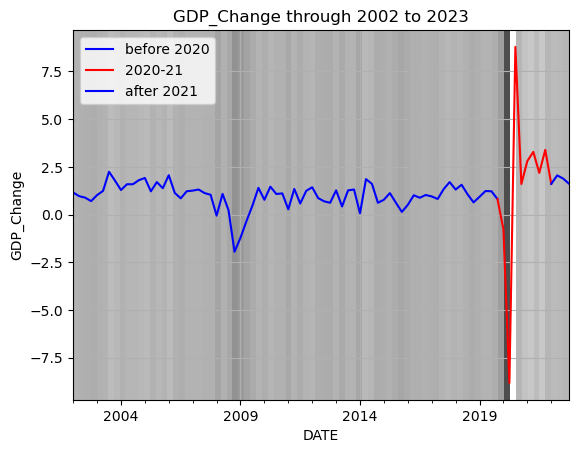

In [33]:
plot(df, "GDP_Change")

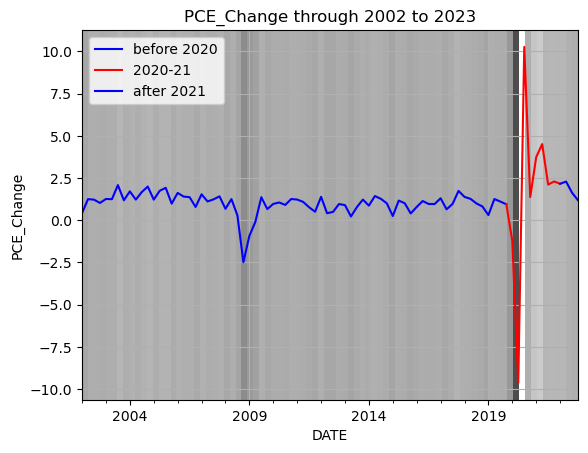

In [34]:
plot(df, "PCE_Change")

In [35]:
df["year"] = df.DATE.dt.year.astype("int")

In [36]:
crisis2008 = df.loc[((df.year>=2008) &
                (df.year<=2009))]
crisis2020 = df.loc[((df.year>=2020) &
                 (df.year<=2021))]

normal = df.loc[(df.year<2008) |
                ((df.year>2009) & (df.year<2020))|
                (df.year>2021)]

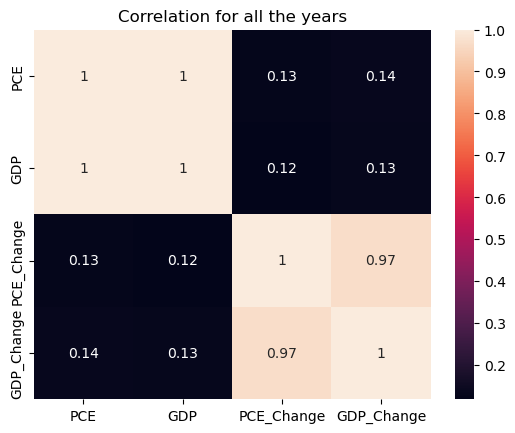

In [37]:
g = sns.heatmap(df.drop("year", 
                        axis="columns").corr(), annot=True)
g.set(title="Correlation for all the years")
fig = g.get_figure()
fig.savefig("corr-total.jpeg")

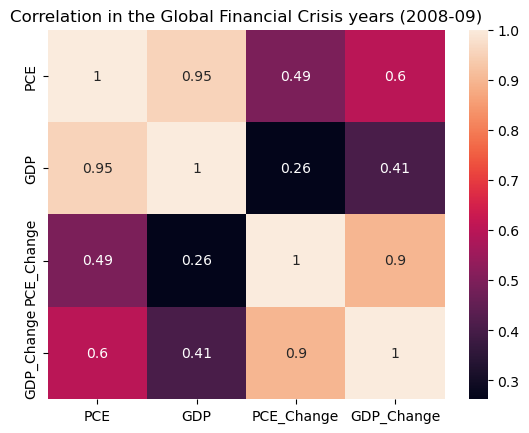

In [38]:
g = sns.heatmap(crisis2008.drop("year", 
                            axis="columns").corr(), annot=True)
g.set(title="Correlation in the Global Financial Crisis years (2008-09)")
fig = g.get_figure()
fig.savefig("corr-crisis2008.jpeg")

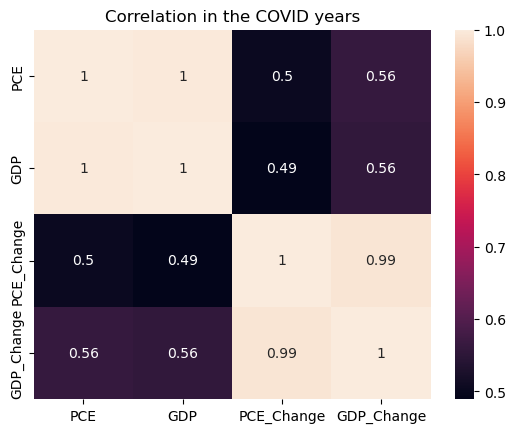

In [39]:
g = sns.heatmap(crisis2020.drop("year", 
                            axis="columns").corr(), annot=True)
g.set(title="Correlation in the COVID years")
fig = g.get_figure()
fig.savefig("corr-crisis2020.jpeg")

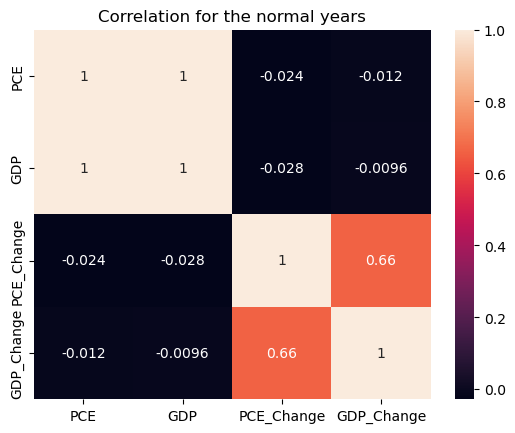

In [40]:
g = sns.heatmap(normal.drop("year", 
                        axis="columns").corr(), annot=True)
g.set(title="Correlation for the normal years")
fig = g.get_figure()
fig.savefig("corr-normal.jpeg")

In [41]:
from statsmodels.tsa.stattools import adfuller
def check_for_stationary(df, df_type):
  p_value = {}
  test_stats = {}
  for c in df.drop(["DATE", "category", "year"],
                  axis="columns").columns.values:
    result = adfuller(df[c].values)
    p_value[c] = result[1]
    test_stats[c] = result[0]
  print("For " + df_type + " years:\n")
  print("p-val: ", p_value, sep="\n")
  print()
  print("test statistcs:",test_stats, sep="\n")
  print()
  stationary = {}
  for k in p_value.keys():
    if p_value[k] < 0.05 or test_stats[k] >= -0.01:
      print(k + " is stationary")
    else:
      print(k + " is not stationary")

In [42]:
check_for_stationary(df, "All")

For All years:

p-val: 
{'PCE': 0.9984430594820441, 'GDP': 0.9987645203882808, 'PCE_Change': 1.3617787473396247e-18, 'GDP_Change': 1.1255221739056989e-17}

test statistcs:
{'PCE': 1.8499243516033095, 'GDP': 2.0765439273827693, 'PCE_Change': -10.460663234105166, 'GDP_Change': -10.090496974155753}

PCE is stationary
GDP is stationary
PCE_Change is stationary
GDP_Change is stationary


In [43]:
check_for_stationary(crisis2008, "Global Financial Crisis")

For Global Financial Crisis years:

p-val: 
{'PCE': 0.0, 'GDP': 0.0022359865415864243, 'PCE_Change': 0.08494579683606124, 'GDP_Change': 0.20894354613358646}

test statistcs:
{'PCE': -89.22925423391115, 'GDP': -3.8738456120088154, 'PCE_Change': -2.640325910352761, 'GDP_Change': -2.1925962789135505}

PCE is stationary
GDP is stationary
PCE_Change is not stationary
GDP_Change is not stationary


In [44]:
check_for_stationary(crisis2020, "COVID")

For COVID years:

p-val: 
{'PCE': 0.6530580343700993, 'GDP': 0.9615254885815657, 'PCE_Change': 0.0334784217577642, 'GDP_Change': 0.29113779238561677}

test statistcs:
{'PCE': -1.246999947771814, 'GDP': 0.03749854311263567, 'PCE_Change': -3.0154291256921275, 'GDP_Change': -1.9896314002901971}

PCE is not stationary
GDP is stationary
PCE_Change is stationary
GDP_Change is not stationary
